## MY CNN model for Ucohead with the model tested 10-mokey-species

Test CNN model
as following the tutorial : https://www.tensorflow.org/tutorials/images/classification

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [7]:
BATCH_SIZE = 32
# IMG_SIZE = (500,500)
# IMG_W = 500
# IMG_H = 500
IMG_SIZE = (40,40)
IMG_W = 40
IMG_H = 40
# IMG_SIZE = (200,200)
# IMG_W = 200
# IMG_H = 200

In [8]:
train_dataset = image_dataset_from_directory("../dataset/train/",
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 7818 files belonging to 10 classes.


In [9]:
validation_dataset = image_dataset_from_directory("../dataset/test/",
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 image_size=IMG_SIZE)

Found 3806 files belonging to 10 classes.


In [10]:
class_names = train_dataset.class_names
class_names

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

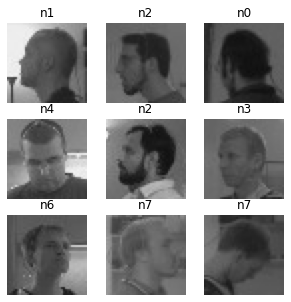

In [11]:
plt.figure(figsize=(5,5))
for images, labels in train_dataset.take(1):
    first_image=images[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 40, 40, 3)
(32,)


In [13]:
first_image.shape

TensorShape([40, 40, 3])

In [14]:
# AUTOTUNE =tf.data.experimental.AUTOTUNE

# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

AUTOTUNE =tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
from tensorflow.keras import layers

In [16]:
data_augmentation = keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_H, IMG_W, 3)),
#     layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1, input_shape=(IMG_H, IMG_W, 3)),
    layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

#### Standardize the data

The RGB channel values are in the ```[0, 255]``` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the ```[0,1]``` range by using a Rescaling layer.

In [17]:
normalized_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [27]:
num_classes = 10
model = Sequential([
#     layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_H, IMG_W, 3)),
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding = "same", activation ="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, padding = "same", activation ="relu"),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding = "same", activation ="relu"),
    layers.Dropout(0.2),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

In [28]:
# #### Ucohead original


# def my_model(input_shape, drop_rate): # dr0.2/
#     model = Sequential([
#         Conv2D(filters=32, input_shape=input_shape, kernel_size=(3,3), strides=2, activation = 'relu'),
#         Dropout(drop_rate),
#         Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
#         Dropout(drop_rate),
#         Dense(units=32, activation='relu')
# #         Dense(units=1, activation='softmax')
#     ])
#     return model

In [29]:
# drop_rate = 0.5 #looks it works better than 0.5

# model = my_model(first_image.shape, drop_rate)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
early_stopping=EarlyStopping(monitor="val_loss", patience=50, verbose=2)

In [38]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 40, 40, 3)         0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)       

In [40]:
epochs=200
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping])

Epoch 1/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3648 - accuracy: 0.8575 - val_loss: 0.2501 - val_accuracy: 0.9023
Epoch 2/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3730 - accuracy: 0.8514 - val_loss: 0.2622 - val_accuracy: 0.8954
Epoch 3/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3532 - accuracy: 0.8573 - val_loss: 0.2909 - val_accuracy: 0.8836
Epoch 4/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3575 - accuracy: 0.8574 - val_loss: 0.2643 - val_accuracy: 0.8952
Epoch 5/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3518 - accuracy: 0.8616 - val_loss: 0.2583 - val_accuracy: 0.8978
Epoch 6/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3531 - accuracy: 0.8603 - val_loss: 0.3127 - val_accuracy: 0.8805
Epoch 7/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3541 - accuracy: 0.8612 - val_loss: 0.2453 - val_accuracy: 0.9038

Epoch 58/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3155 - accuracy: 0.8761 - val_loss: 0.2501 - val_accuracy: 0.9028
Epoch 59/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3260 - accuracy: 0.8744 - val_loss: 0.2671 - val_accuracy: 0.8986
Epoch 60/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3260 - accuracy: 0.8718 - val_loss: 0.2377 - val_accuracy: 0.9049
Epoch 61/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3129 - accuracy: 0.8735 - val_loss: 0.2735 - val_accuracy: 0.8875
Epoch 62/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3121 - accuracy: 0.8773 - val_loss: 0.2272 - val_accuracy: 0.9146
Epoch 63/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3114 - accuracy: 0.8740 - val_loss: 0.2463 - val_accuracy: 0.9036
Epoch 64/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3301 - accuracy: 0.8690 - val_loss: 0.2525 - val_accuracy:

Epoch 115/200
245/245 [==============================] - 1s 6ms/step - loss: 0.2941 - accuracy: 0.8850 - val_loss: 0.2201 - val_accuracy: 0.9138
Epoch 116/200
245/245 [==============================] - 1s 6ms/step - loss: 0.2914 - accuracy: 0.8873 - val_loss: 0.2315 - val_accuracy: 0.9096
Epoch 117/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3082 - accuracy: 0.8777 - val_loss: 0.2182 - val_accuracy: 0.9157
Epoch 118/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3018 - accuracy: 0.8807 - val_loss: 0.2377 - val_accuracy: 0.9020
Epoch 119/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3017 - accuracy: 0.8842 - val_loss: 0.2198 - val_accuracy: 0.9154
Epoch 120/200
245/245 [==============================] - 1s 6ms/step - loss: 0.2942 - accuracy: 0.8856 - val_loss: 0.2335 - val_accuracy: 0.9109
Epoch 121/200
245/245 [==============================] - 1s 6ms/step - loss: 0.3045 - accuracy: 0.8813 - val_loss: 0.2438 - val_ac

245/245 [==============================] - 1s 6ms/step - loss: 0.2838 - accuracy: 0.8880 - val_loss: 0.2169 - val_accuracy: 0.9138
Epoch 172/200
245/245 [==============================] - 1s 6ms/step - loss: 0.2864 - accuracy: 0.8908 - val_loss: 0.2122 - val_accuracy: 0.9157
Epoch 173/200
245/245 [==============================] - 1s 6ms/step - loss: 0.2841 - accuracy: 0.8886 - val_loss: 0.2454 - val_accuracy: 0.9067
Epoch 174/200
245/245 [==============================] - 1s 6ms/step - loss: 0.2882 - accuracy: 0.8883 - val_loss: 0.2292 - val_accuracy: 0.9112
Epoch 175/200
245/245 [==============================] - 1s 6ms/step - loss: 0.2871 - accuracy: 0.8911 - val_loss: 0.2093 - val_accuracy: 0.9204
Epoch 176/200
245/245 [==============================] - 1s 6ms/step - loss: 0.2804 - accuracy: 0.8860 - val_loss: 0.2412 - val_accuracy: 0.9080
Epoch 177/200
245/245 [==============================] - 1s 6ms/step - loss: 0.2739 - accuracy: 0.8926 - val_loss: 0.2290 - val_accuracy: 0.9115

In [35]:
# prediction_layer = tf.keras.layers.Dense(10, activation="softmax")  
# #default -linear, 0.5375
# #softmax, 0.4000
# #relu, 0.6250

In [49]:
# inputs = tf.keras.Input(shape=(IMG_W, IMG_H, 3))
# # x = data_augmentation(inputs)
# x = inputs
# # x = rescale(x)
# x = model(x)
# outputs = prediction_layer(x)
# cnn_model = tf.keras.Model(inputs, outputs)

In [41]:
# new_img_path = "../large.jpg"

new_img_path ="../side_view.jpg"

new_img = keras.preprocessing.image.load_img(new_img_path, target_size=(IMG_H, IMG_W, 3))
img_array = keras.preprocessing.image.img_to_array(new_img)
img_array = tf.expand_dims(img_array, 0) # create a batch

prediction = model.predict(img_array)
score = tf.nn.softmax(prediction[0])

print("This image most likely belongs to {} with {:.2f} percent confidence.". format(class_names[np.argmax(score)], 100*np.max(score)))

This image most likely belongs to n4 with 80.78 percent confidence.


In [58]:
# base_lr = 0.0001
# cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_lr), 
# #                   loss = tf.keras.losses.categorical_crossentropy(from_logits=True),
#                   loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                   metrics=['accuracy'])

In [59]:
# from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

# class TrainingCallback(Callback):
#     def on_train_begin(self, logs=None):
#         print("Starting training ...")
#     def on_train_end(self, logs=None):
#         print("Finished training!")

# early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)

In [60]:
# initial_epochs = 200
# loss0, accuracy0 = cnn_model.evaluate(validation_dataset)

In [61]:
# print("initial loss : {:.2f}".format(loss0))
# print("initial accuracy : {:.2f}".format(accuracy0))

In [62]:
# # history = cnn_model.fit(train_dataset,
# #                        epochs=initial_epochs,
# #                        validation_data=validation_dataset,
# #                        callbacks=[TrainingCallback(), early_stopping])
# history = cnn_model.fit(train_dataset,
#                        epochs=initial_epochs,
#                        validation_data=validation_dataset,
#                        callbacks=[TrainingCallback()])

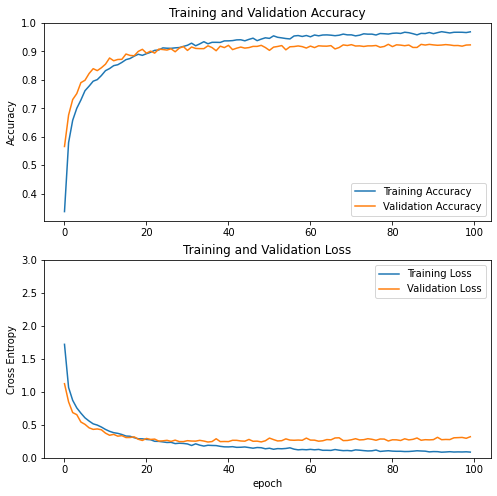

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [334]:
# import pickle
# with open("./cnn_model_test00",'wb') as file_pi:
#     pickle.dump(history_fine.history, file_pi)

In [335]:
# test_load = pickle.load(open("./cnn_model_test00",'rb'))
# test_load['loss']